## DESI EDR EMPCA Analysis - Data - Distribution of targets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from matplotlib.colors import ListedColormap, Normalize
import astropy.units as u
import healpy as hp
import os
from desitarget.sv1 import sv1_targetmask    # For SV1
from desitarget.sv2 import sv2_targetmask    # For SV2
from desitarget.sv3 import sv3_targetmask    # For SV3

In [2]:
## DESI EDR Meta-Data for 2,044,588 objects
zpix = pd.read_parquet('Data/zpix_data.parquet')  # Load the DESI Meta DataFrame from the Parquet file
print(zpix)

                  targetid   survey program  healpix         z  zwarn  \
0        39633414185291967      sv3    dark    15341  0.655598      0   
1        39633414185291844      sv3  bright    15341  0.026611      0   
2        39633414185291911      sv3  bright    15341  0.181553      0   
3        39633414185291937      sv3    dark    15341  0.832186      0   
4        39633416995473409      sv3    dark    15352  0.673905      4   
...                    ...      ...     ...      ...       ...    ...   
2044583  39632997007232484  special    dark    14886  0.528624      0   
2044584  39632997007231659  special    dark    14886  0.814740      4   
2044585  39632997007232175  special    dark    14886  0.109031      4   
2044586  39632997007233840  special    dark    14886  1.179169      4   
2044587  39632997007235467  special    dark    14886 -0.000120      0   

         coadd_fiberstatus spectype  mean_fiber_ra  mean_fiber_dec  \
0                        0   GALAXY      273.42926   

1979269
96.8052732384226 % of DESI objects are primary spectra



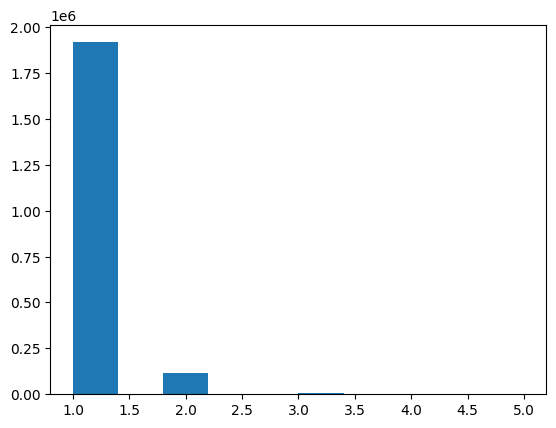

In [6]:
## Primary targets - breakdown on number of spectra

is_primary = zpix['zcat_primary']==1
zpix_cat = zpix[is_primary]
print(len(zpix_cat))
print(len(zpix_cat)/len(zpix)*100,"% of DESI objects are primary spectra")
plt.hist(zpix['zcat_nspec'])

print()

In [7]:
sv1_desi_tgt = zpix_cat['sv1_desi_target']
sv2_desi_tgt = zpix_cat['sv2_desi_target']
sv3_desi_tgt = zpix_cat['sv3_desi_target']

## DESI Bitmasks
sv1_desi_mask = sv1_targetmask.desi_mask
sv2_desi_mask = sv2_targetmask.desi_mask
sv3_desi_mask = sv3_targetmask.desi_mask

## Candidate selection

is_bgs = (sv1_desi_tgt & sv1_desi_mask['BGS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['BGS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['BGS_ANY'] != 0) #bright-galaxy-survey
is_lrg = (sv1_desi_tgt & sv1_desi_mask['LRG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['LRG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['LRG'] != 0) #luminous-red-galaxy
is_elg = (sv1_desi_tgt & sv1_desi_mask['ELG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['ELG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['ELG'] != 0) #emission-line-galaxy
is_qso = (sv1_desi_tgt & sv1_desi_mask['QSO'] != 0)|(sv2_desi_tgt & sv2_desi_mask['QSO'] != 0)|(sv3_desi_tgt & sv3_desi_mask['QSO'] != 0) #quasar
is_mws = (sv1_desi_tgt & sv1_desi_mask['MWS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['MWS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['MWS_ANY'] != 0) #milky-way-stars
is_scnd = (sv1_desi_tgt & sv1_desi_mask['SCND_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['SCND_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['SCND_ANY'] != 0) #secondary-targets


In [221]:
ra_degrees = np.array(zpix_cat['mean_fiber_ra'])
dec_degrees = np.array(zpix_cat['mean_fiber_dec'])
ra_rad = np.array(np.deg2rad(zpix_cat['mean_fiber_ra']))
dec_rad = np.array(np.deg2rad(zpix_cat['mean_fiber_dec']))

zpix_mws = zpix_cat[is_mws]
zpix_bgs = zpix_cat[is_bgs]
zpix_elg = zpix_cat[is_elg]
zpix_qso = zpix_cat[is_qso]
zpix_scnd = zpix_cat[is_scnd]

zpix_mws_star = zpix_mws[zpix_mws['spectype'] == 'STAR']
zpix_bgs_star = zpix_bgs[zpix_bgs['spectype'] == 'STAR']

zpix_star = zpix_cat[zpix_cat['spectype']=='STAR']

ra_degrees_star = np.array(zpix_star['mean_fiber_ra'])
dec_degrees_star = np.array(zpix_star['mean_fiber_dec'])

ra_degrees_mws_star = np.array(zpix_mws_star['mean_fiber_ra'])
dec_degrees_mws_star = np.array(zpix_mws_star['mean_fiber_dec'])

ra_degrees_bgs_star = np.array(zpix_bgs_star['mean_fiber_ra'])
dec_degrees_bgs_star = np.array(zpix_bgs_star['mean_fiber_dec'])

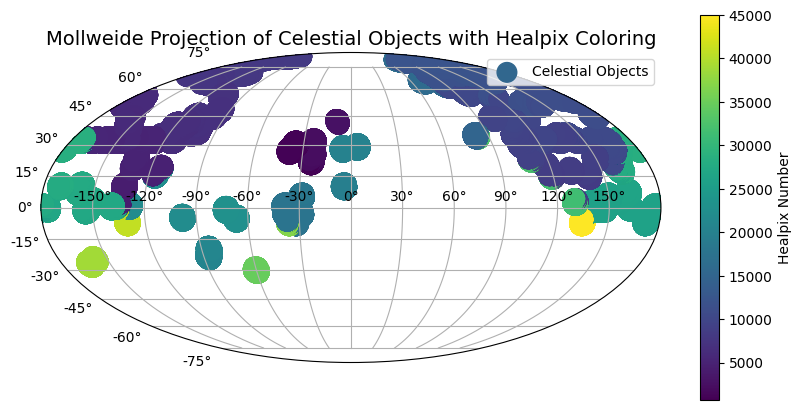

In [48]:
# Example Healpix numbers
healpix_numbers = zpix_cat['healpix']

# Create a SkyCoord object with units
coords = SkyCoord(ra=ra_degrees * u.deg, dec=dec_degrees * u.deg, frame='icrs')

# Define a colormap for Healpix numbers
cmap = plt.get_cmap('viridis', len(set(healpix_numbers)))

# Create a normalization to map Healpix numbers to the colormap
norm = Normalize(vmin=min(healpix_numbers), vmax=max(healpix_numbers))

# Create a Mollweide projection plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide')

# Plot celestial objects with color based on Healpix
sc = ax.scatter(-coords.ra.wrap_at(180 * u.deg).radian, coords.dec.radian, 
                s=200, c=healpix_numbers, cmap=cmap, norm=norm, marker='o', label='Celestial Objects')

# Create a colorbar to show the Healpix number legend
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Healpix Number')

# Customize the plot
ax.grid(True)

# Add title and legend
plt.title('Mollweide Projection of Celestial Objects with Healpix Coloring', fontsize=14)
plt.legend(loc='upper right')

# Save the plot as a high-resolution image suitable for publication
plt.savefig('celestial_objects_mollweide_healpix.png', dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()

## Target Density

1407


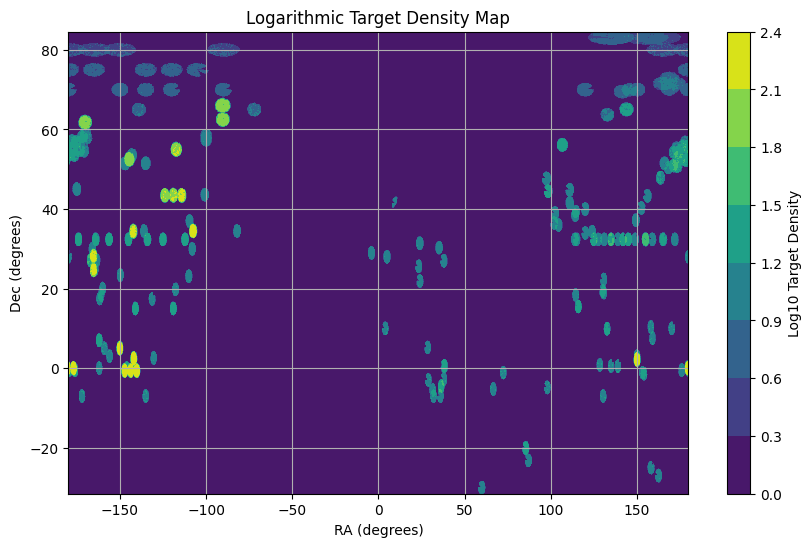

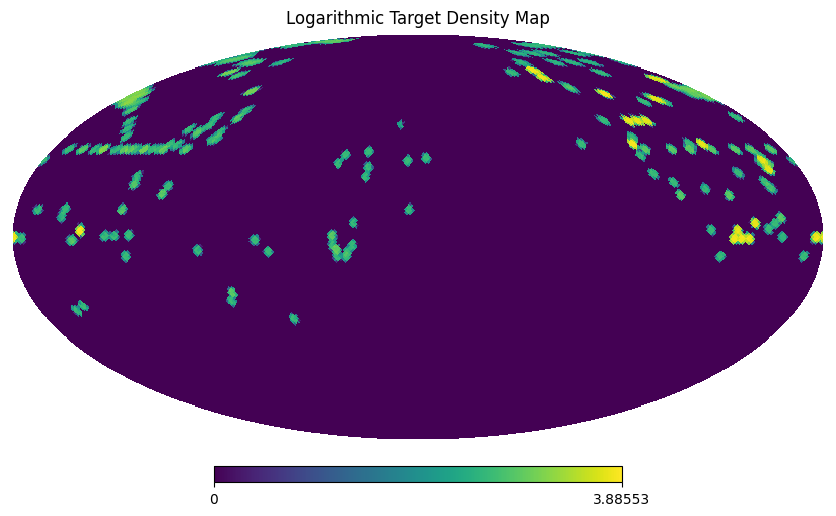

In [180]:
coords = SkyCoord(ra=ra_degrees * u.deg, dec=dec_degrees * u.deg, frame='icrs')
# Define the number of bins for the density map
n_bins = int(np.round(np.sqrt(len(ra_degrees))))
print(n_bins)

# Calculate the star density map
star_density, ra_edges, dec_edges = np.histogram2d(
    coords.ra.wrap_at(180 * u.deg).radian,
    coords.dec.radian,
    bins=(n_bins, n_bins)
)

# Take the logarithm (base 10) of the star density
star_density_log10 = np.log10(star_density + 1)  # Adding 1 to avoid log(0)

# Adjust the dimensions of ra_edges and dec_edges
ra_centers = np.degrees((ra_edges[:-1] + ra_edges[1:]) / 2)
dec_centers = np.degrees((dec_edges[:-1] + dec_edges[1:]) / 2)

# Create a grid for plotting
ra_mesh, dec_mesh = np.meshgrid(ra_centers, dec_centers)

# Create a logarithmic star density map
plt.figure(figsize=(10, 6))
plt.contourf(ra_mesh, dec_mesh, star_density_log10.T, cmap='viridis')  # Transpose the density for correct plotting
plt.colorbar(label='Log10 Target Density')
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Logarithmic Target Density Map')
plt.grid(True)
plt.show()

# Create a Healpix map
nside = 64  # Choose an appropriate nside value

pix = hp.ang2pix(nside, theta=np.pi / 2 - dec_rad, phi=ra_rad)

# Calculate the star density map
star_density = np.bincount(pix, minlength=hp.nside2npix(nside))

# Take the logarithm (base 10) of the star density
star_density_log10 = np.log10(star_density + 1)  # Adding 1 to avoid log(0)

# Create a Mollweide projection plot
hp.mollview(star_density_log10, title='Logarithmic Target Density Map', cmap='viridis')

# Show the plot
plt.show()

## Star Density

1407


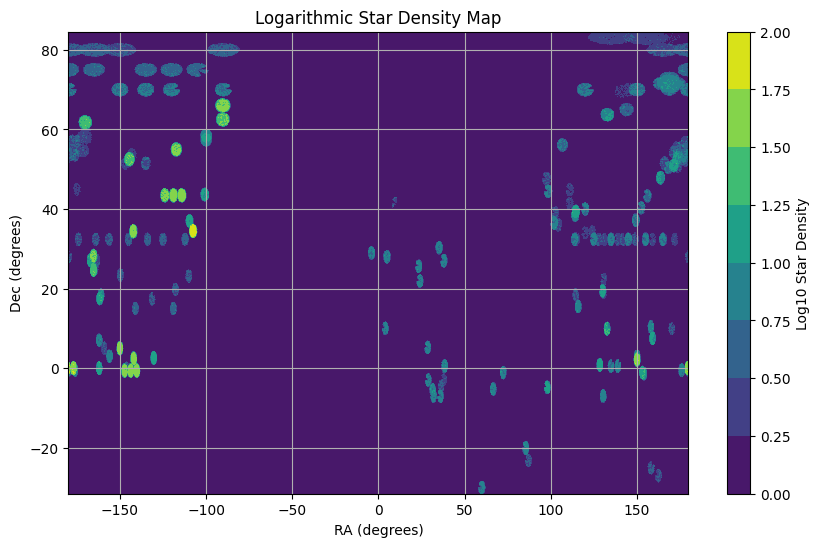

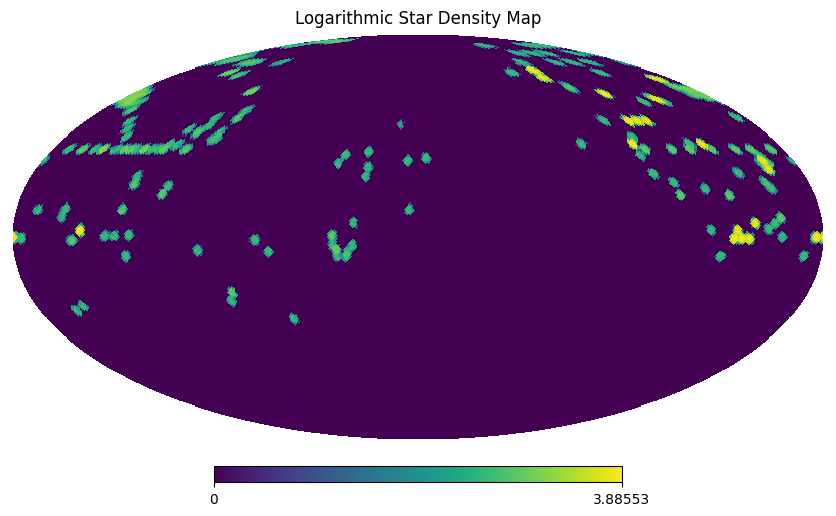

In [78]:
coords = SkyCoord(ra=ra_degrees_bgs_star * u.deg, dec=dec_degrees_bgs_star * u.deg, frame='icrs')
# Define the number of bins for the density map
n_bins = int(np.round(np.sqrt(len(ra_degrees))))
print(n_bins)

# Calculate the star density map
star_density, ra_edges, dec_edges = np.histogram2d(
    coords.ra.wrap_at(180 * u.deg).radian,
    coords.dec.radian,
    bins=(n_bins, n_bins)
)

# Take the logarithm (base 10) of the star density
star_density_log10 = np.log10(star_density + 1)  # Adding 1 to avoid log(0)

# Adjust the dimensions of ra_edges and dec_edges
ra_centers = np.degrees((ra_edges[:-1] + ra_edges[1:]) / 2)
dec_centers = np.degrees((dec_edges[:-1] + dec_edges[1:]) / 2)

# Create a grid for plotting
ra_mesh, dec_mesh = np.meshgrid(ra_centers, dec_centers)

# Create a logarithmic star density map
plt.figure(figsize=(10, 6))
plt.contourf(ra_mesh, dec_mesh, star_density_log10.T, cmap='viridis')  # Transpose the density for correct plotting
plt.colorbar(label='Log10 Star Density')
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Logarithmic Star Density Map')
plt.grid(True)
plt.show()

# Create a Healpix map
nside = 64  # https://datalab.noirlab.edu/desi/ states n = 64, healpix resolution

pix = hp.ang2pix(nside, theta=np.pi / 2 - dec_rad, phi=ra_rad)

# Calculate the star density map
star_density = np.bincount(pix, minlength=hp.nside2npix(nside))

# Take the logarithm (base 10) of the star density
star_density_log10 = np.log10(star_density + 1)  # Adding 1 to avoid log(0)

# Create a Mollweide projection plot
hp.mollview(star_density_log10, title='Logarithmic Star Density Map', cmap='viridis')

# Show the plot
plt.show()

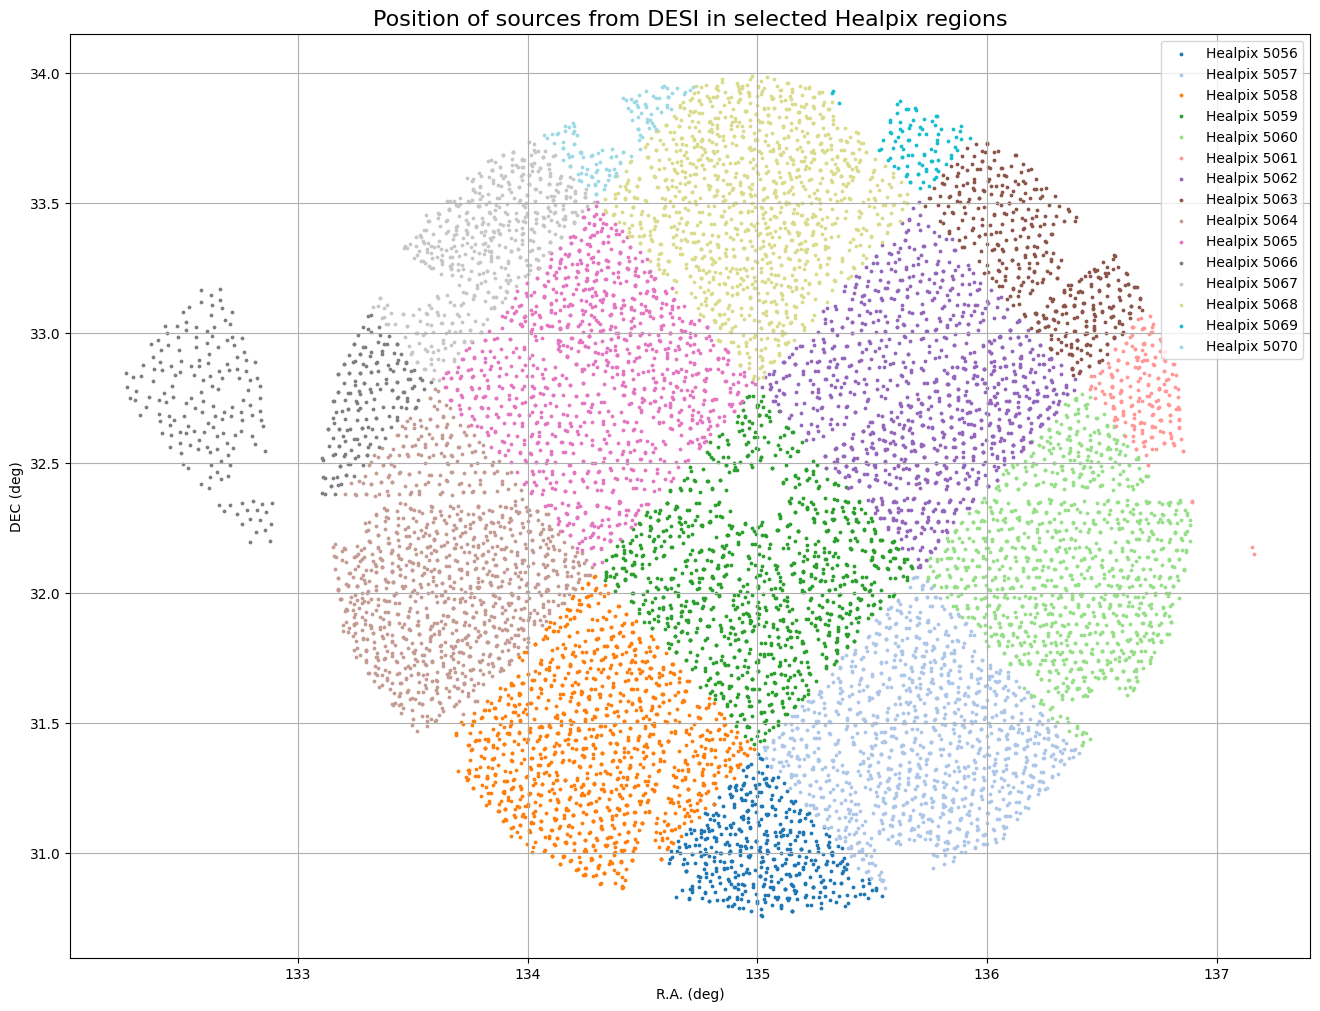

In [219]:
selected_healpix = healpix[215:230]

# Create a figure and axis
plt.figure(figsize=(16, 12))

# Define a list of colors for the 10 different regions
colors = plt.cm.tab20(np.linspace(0, 1, len(selected_healpix)))

# Plot data from each selected Healpix region with a unique color
for hpx, color in zip(selected_healpix, colors):
    sel = (zpix_cat['healpix'] == hpx)
    tsel = zpix_cat[sel]
    
    plt.scatter(
        tsel['mean_fiber_ra'],
        tsel['mean_fiber_dec'],
        s=3,
        label=f'Healpix {hpx}',
        color=color
    )

plt.title('Position of sources from DESI in selected Healpix regions', fontsize=16)
plt.xlabel('R.A. (deg)')
plt.ylabel('DEC (deg)')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)

1061
                  targetid survey program  healpix         z  zwarn  \
982879   39628521575813651    sv1    dark     5059  1.606102      4   
982883   39628521580005095    sv1    dark     5059  0.836875      0   
982884   39628516433597456    sv1  bright     5059 -0.001996   1570   
982885   39628516433597432    sv1    dark     5059 -0.001996   1570   
982886   39628521580005493    sv1  bright     5059  0.039290      0   
...                    ...    ...     ...      ...       ...    ...   
1366005  39632934977669351    sv1  bright     5059  0.000093      0   
1366010  39632934977668126    sv1  bright     5059  0.268235      0   
1366011  39632934977668179    sv1    dark     5059  1.598139      4   
1366012  39632934977668337    sv1  bright     5059  0.267535      0   
1366013  39632934977668467    sv1    dark     5059  2.343687      0   

         coadd_fiberstatus spectype  mean_fiber_ra  mean_fiber_dec  \
982879                   0   GALAXY      134.38054       32.007744   
98

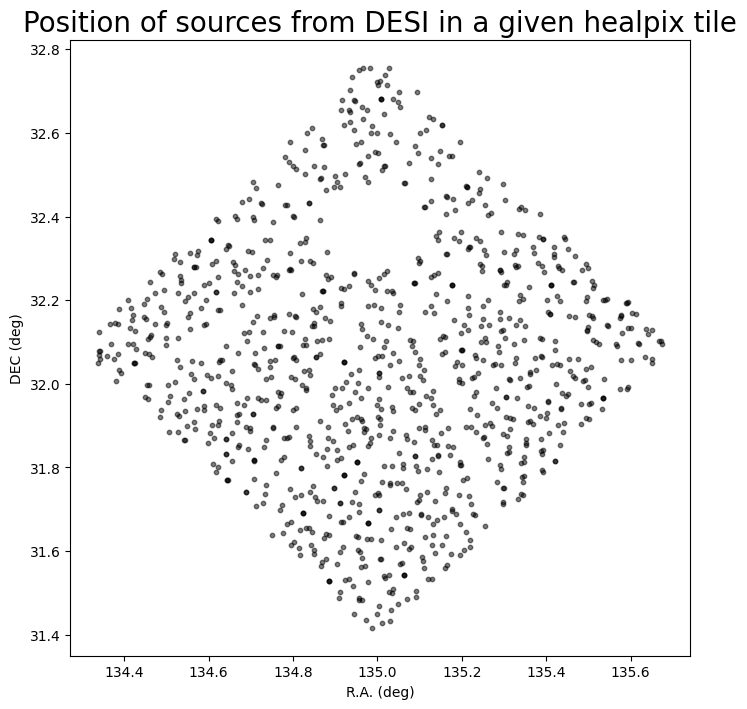

In [220]:
healpix = np.array(zpix_cat['healpix'].unique())
healpix = np.sort(healpix)
hpx = 5059
sel = (zpix_cat['healpix'] == hpx)

tsel = zpix_cat[sel]

plt.figure(figsize = (8, 8))

plt.title('Position of sources from DESI in a given healpix tile', fontsize = 20)
plt.scatter(tsel['mean_fiber_ra'], tsel['mean_fiber_dec'], color = 'black', s=10, alpha=0.5)
plt.xlabel('R.A. (deg)')
plt.ylabel('DEC (deg)')

print(len(tsel['mean_fiber_ra']))
print(tsel)

                  targetid survey program  healpix         z  zwarn  \
982889   39628521580004131    sv1  bright     5059  0.000078      0   
982894   39628521580005821    sv1  bright     5059  0.000024      0   
983020   39628511282992371    sv1  bright     5059  0.000321      0   
983028   39628511287182400    sv1    dark     5059  0.000495      0   
983057   39628516437788657    sv1  bright     5059 -0.001996   1570   
...                    ...    ...     ...      ...       ...    ...   
1364672  39628526718028668    sv1    dark     5059 -0.000166      0   
1364677  39632929877396511    sv1  bright     5059 -0.000030      0   
1364726  39632929873202861    sv1    dark     5059  0.093171      0   
1364750  39632929877394004    sv1  bright     5059  0.000081      0   
1364752  39632929877394616    sv1    dark     5059  1.916530      0   

         coadd_fiberstatus spectype  mean_fiber_ra  mean_fiber_dec  \
982889                   0     STAR      134.45709       31.964610   
982894 

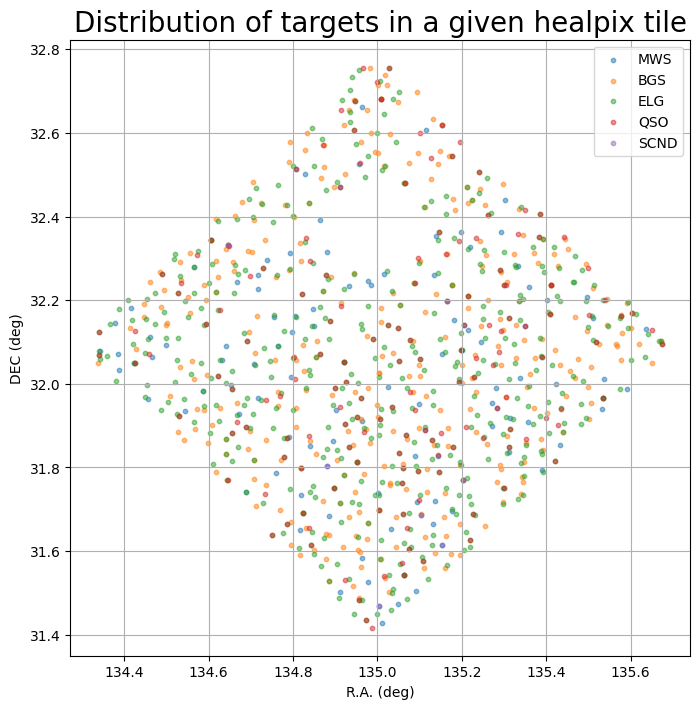

In [232]:
# List of datasets
datasets = [zpix_mws, zpix_bgs, zpix_elg, zpix_qso, zpix_scnd]
dataset_name = ['MWS', 'BGS', 'ELG', 'QSO', 'SCND']
hpx = 5059
# Create a figure and axis
plt.figure(figsize=(8, 8))
plt.title('Distribution of targets in a given healpix tile', fontsize=20)
plt.xlabel('R.A. (deg)')
plt.ylabel('DEC (deg)')

# Plot each dataset with a label
for i in range(len(datasets)):
    dataset = datasets[i]
    tsel = dataset[dataset['healpix'] == hpx]
    print(tsel)
    plt.scatter(
        tsel['mean_fiber_ra'],
        tsel['mean_fiber_dec'],
        s=10,
        alpha=0.5,
        label=dataset_name[i],  # Specify the dataset name as the label
    )

# Add a legend
plt.legend()
plt.grid()
# Show the plot
plt.show()